<a href="https://www.kaggle.com/code/chris36/software-defects-binary-classification?scriptVersionId=148084947" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf 
import  keras 
import matplotlib
from matplotlib import pyplot as plt 
from keras import layers 
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

# print tf version 
print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.12.0
/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


== GET DATA == 

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e23/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv")

== INSPECT DATA == 

In [3]:
# train shape/dims 
print(f"train shape : {train.shape}")
print(f"test shape : {test.shape}")

train shape : (101763, 23)
test shape : (67842, 22)


In [4]:
 #train head 
train.head(3)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False


In [5]:
test.head(3)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,101763,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,101764,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,101765,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0


In [6]:
train.isna().sum().sum()

0

In [7]:
#train infos
train.info

<bound method DataFrame.info of             id    loc  v(g)  ev(g)  iv(g)      n        v     l      d      i  \
0            0   22.0   3.0    1.0    2.0   60.0   278.63  0.06  19.56  14.25   
1            1   14.0   2.0    1.0    2.0   32.0   151.27  0.14   7.00  21.11   
2            2   11.0   2.0    1.0    2.0   45.0   197.65  0.11   8.05  22.76   
3            3    8.0   1.0    1.0    1.0   23.0    94.01  0.19   5.25  17.86   
4            4   11.0   2.0    1.0    2.0   17.0    60.94  0.18   5.63  12.44   
...        ...    ...   ...    ...    ...    ...      ...   ...    ...    ...   
101758  101758   10.0   2.0    1.0    1.0   28.0   122.98  0.15   6.60  18.63   
101759  101759   27.0   5.0    4.0    1.0  107.0   559.93  0.06  18.00  34.17   
101760  101760   26.0   1.0    1.0    1.0   83.0   360.17  0.04  22.75  12.56   
101761  101761   10.0   2.0    1.0    2.0   43.0   191.76  0.15   6.46  29.53   
101762  101762  136.0  18.0   18.0    1.0  296.0  1704.57  0.02  44.82  44.08

In [8]:
# train shape
train.shape

(101763, 23)

In [9]:
train.isna().sum().sum()

0

In [10]:
# turn defects into categorical data 
train["defects"] = train["defects"].astype(np.int32)
train["defects"] = train["defects"].astype("category")

In [11]:
#train = pd.get_dummies(train, columns=['defects'], prefix='', prefix_sep='')
train.tail()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
101758,101758,10.0,2.0,1.0,1.0,28.0,122.98,0.15,6.60,18.63,...,7,0,1,0,11.0,8.0,16.0,12.0,3.0,0
101759,101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,...,23,0,2,0,18.0,20.0,67.0,40.0,9.0,0
101760,101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,0
101761,101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,0
101762,101762,136.0,18.0,18.0,1.0,296.0,1704.57,0.02,44.82,44.08,...,102,1,11,0,22.0,31.0,162.0,135.0,35.0,0


In [12]:
train.describe(include="category")

,defects
count,101763
unique,2
top,0
freq,78699


== 1D EDA ==

In [13]:
train0 = train.copy()

<Axes: xlabel='defects', ylabel='count'>

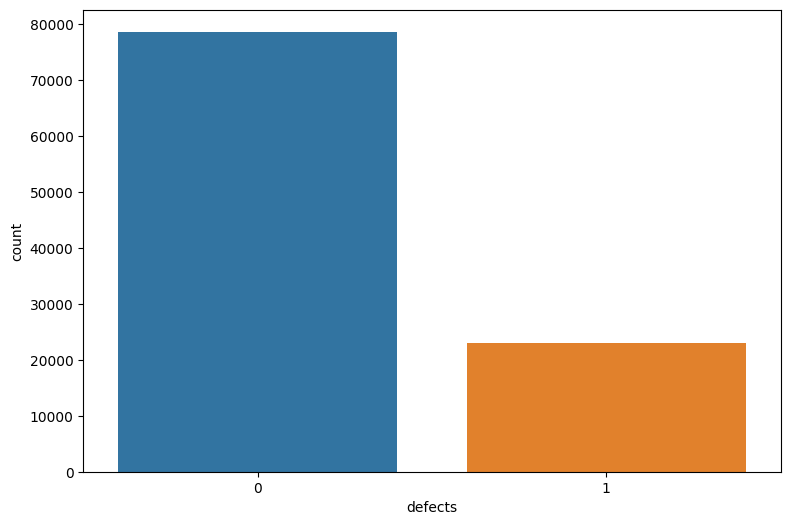

In [14]:
sns.countplot(train,x="defects")

defects is imbalanced. 

response varibale is unbalanced and we need to check for correlation between variables. 

<Axes: >

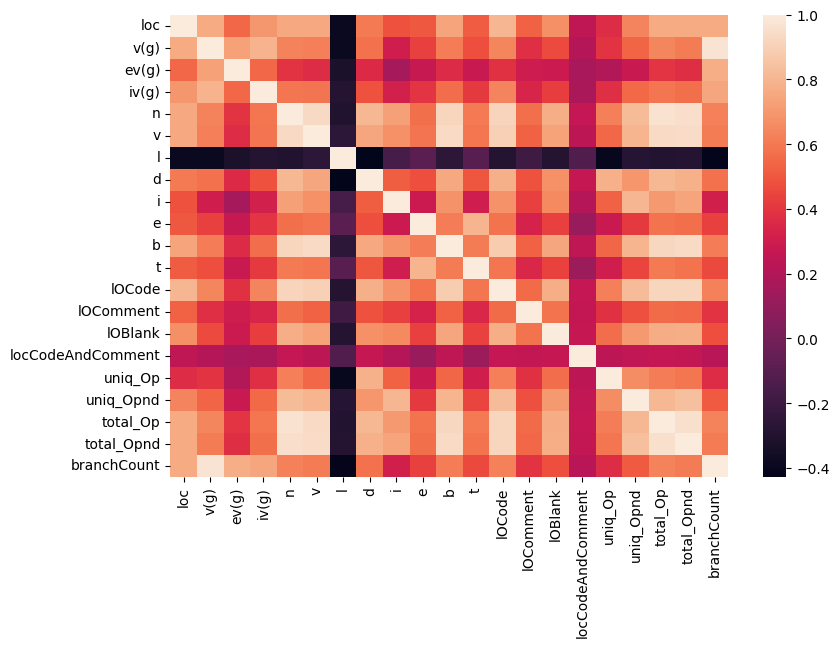

In [15]:
#correlation matrix
cormat = (train.drop(["id","defects"],axis = 1)
          .corr(numeric_only = True)
         )
# heatmap
sns.heatmap(cormat)

In [16]:
# remove strong correlated variables 
import numpy as np

# copy train into train1 
#train0 = train.copy()

train.drop(["id","defects"],axis = 1,inplace = True)

# Create correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.7)]

# Drop features 
train.drop(to_drop, axis=1, inplace=True)
train1 = train.copy()

In [17]:
train1.shape

(101763, 5)

In [18]:
train1.head(3)

,loc,l,e,lOComment,locCodeAndComment
0,22.0,0.06,5448.79,1,0
1,14.0,0.14,936.71,0,0
2,11.0,0.11,1754.01,0,0


== 2D plot ===
correlations with defects : TO finish 

<Axes: xlabel='defects', ylabel='loc'>

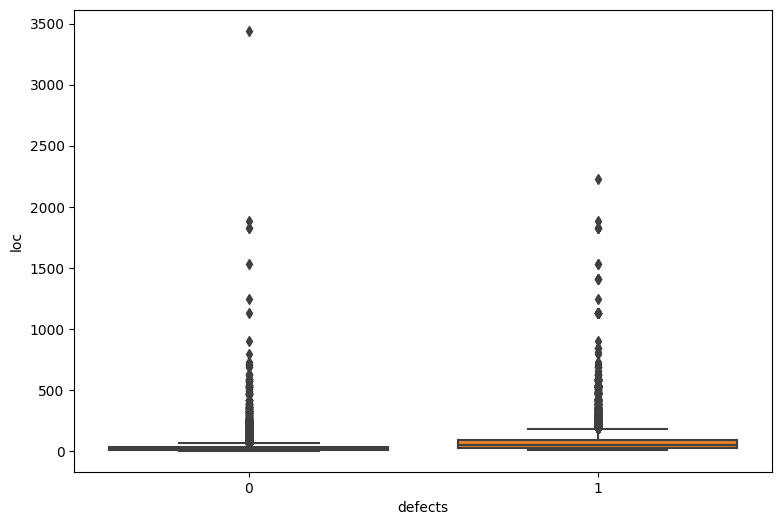

In [19]:
#defects vs loc
sns.boxplot(data = train0,x= "defects",y = "loc", )

The distribution of loc in defects is almost the same, with some outliers withis defects 2 classes.  

<Axes: xlabel='defects', ylabel='l'>

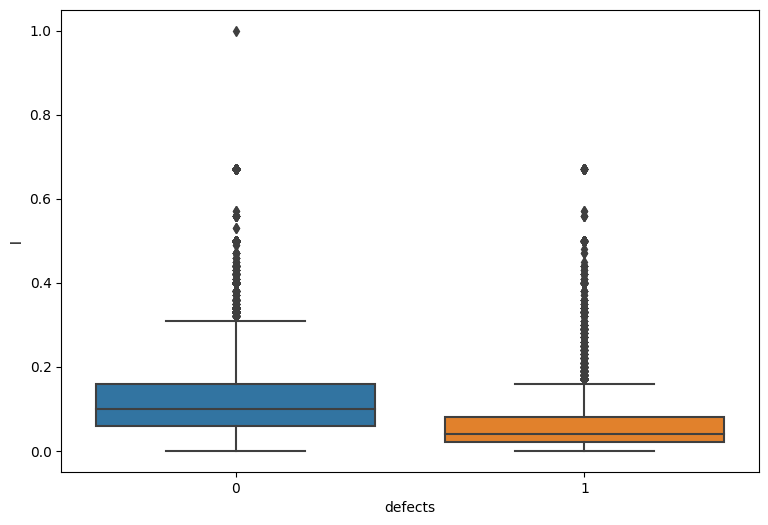

In [20]:
# defects vs 
sns.boxplot(data = train0,x= "defects",y = "l")

This 2 distribution are different within defects classes. 

<Axes: xlabel='defects', ylabel='e'>

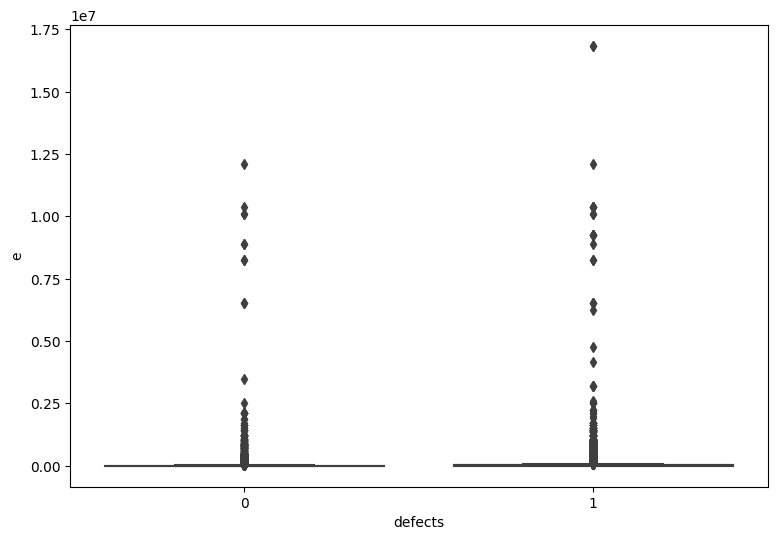

In [21]:
# defects vs e
sns.boxplot(data = train0,x= "defects",y = "e")

The distribution are almost the same,but there many outliers. 

<Axes: xlabel='defects', ylabel='lOComment'>

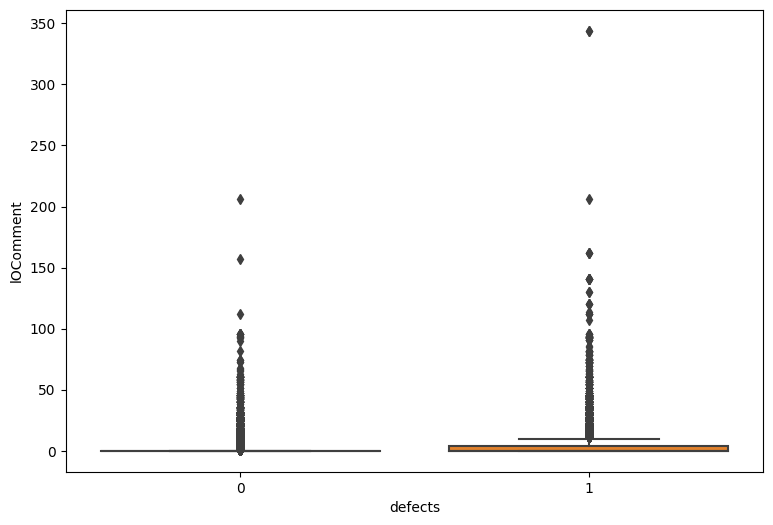

In [22]:
# defects vs loComment
sns.boxplot(data = train0,x= "defects",y = "lOComment")

sub-distributon are almost similar. There is a lot of outliers. 

<Axes: xlabel='defects', ylabel='locCodeAndComment'>

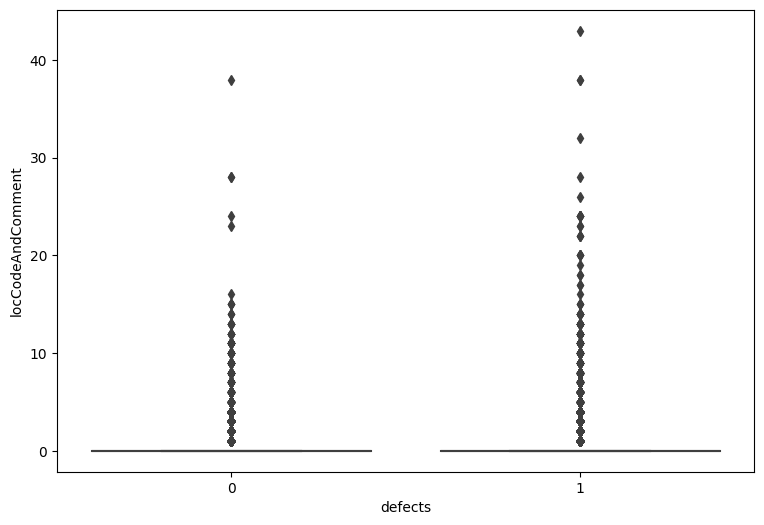

In [23]:
# defects vs e
sns.boxplot(data = train0,x= "defects",y = "locCodeAndComment")

Sub-distribution are almost the same. there is a mor outliers. 

== transform data == 
1. Normalize data
2. dataset to tensor 

Are feature ranges and scales different ?

In [24]:
# features ranges 
train.describe().transpose()[["mean","std"]]

,mean,std
loc,37.347160,54.600401
l,0.111634,0.100096
e,20853.589876,190571.405427
lOComment,1.773945,5.902412
locCodeAndComment,0.196604,0.998906


Let's create a normalizer layer 

In [25]:
# create normalizer
train_normalizer = tf.keras.layers.Normalization(axis=-1)

# fit preproc layer to data
train_normalizer.adapt(np.array(train1))


In [26]:
print(train_normalizer.mean.numpy())

[[3.7347160e+01 1.1163369e-01 2.0853582e+04 1.7739456e+00 1.9660395e-01]]


In [27]:
# normalize train 
train_normalizer(train1)

<tf.Tensor: shape=(101763, 5), dtype=float32, numpy=
array([[-0.28108358, -0.5158468 , -0.08083528, -0.13112484, -0.1968209 ],
       [-0.42760378,  0.28339386, -0.10451201, -0.3005487 , -0.1968209 ],
       [-0.48254883, -0.01632138, -0.10022331, -0.3005487 , -0.1968209 ],
       ...,
       [-0.2078235 , -0.71565694, -0.07850071, -0.3005487 , -0.1968209 ],
       [-0.50086385,  0.383299  , -0.10137759, -0.3005487 , -0.1968209 ],
       [ 1.806829  , -0.91546714,  0.2946812 , -0.13112484, -0.1968209 ]],
      dtype=float32)>

In [28]:
# np array to tensor 
train0_tf = tf.convert_to_tensor(train0.drop(["id","defects"],axis = 1),dtype = tf.float32)
train_tf = tf.convert_to_tensor(train,dtype = "float32")
#train_tf = tf.data.Dataset.from_tensors(train_tf0,name = "data")
y_tf = tf.convert_to_tensor(train0["defects"], dtype=tf.float32)
#train0_tf.shape


== Model ==

= keras model = 

In [29]:
# functional model 
inputs = keras.Input(shape=(train_tf.shape[1]), name="features")
x = train_normalizer(inputs)
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
x = layers.Dense(64, activation="relu", name="dense_3")(x)
x = layers.Dense(64,activation="relu", name="dense_4")(x)
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_1 (Dense)             (None, 64)                384       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable p

In [31]:
#??keras.metrics

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics = ["acc","AUC"])

In [33]:
# define class weight
import sklearn
class_weight = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced", 
                                                classes= [False,True],
                                                y =train0["defects"])

In [34]:
# class weight 
class_weight

array([0.64653299, 2.20610042])

In [35]:
# fit model
%time
history = model.fit(x=train_tf,
         y= y_tf,
         batch_size = 2**13,
         epochs = 100,
         validation_split = 0.4,
         class_weight = {False: class_weight[0],
                         True:  class_weight[1]},
         verbose = False,
         use_multiprocessing=True
         )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [36]:
# test plt
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(2)

,loss,acc,auc,val_loss,val_acc,val_auc,epoch
98,9.830526,0.579278,0.614554,16.807619,0.479856,0.681675,98
99,9.575866,0.565488,0.631380,22.386465,0.419570,0.653847,99


In [37]:
def plot_accuracy(history):
  plt.plot(history.history['acc'], label='train_accuracy')
  plt.plot(history.history['val_acc'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('defects')
  plt.legend()
  plt.grid(True)

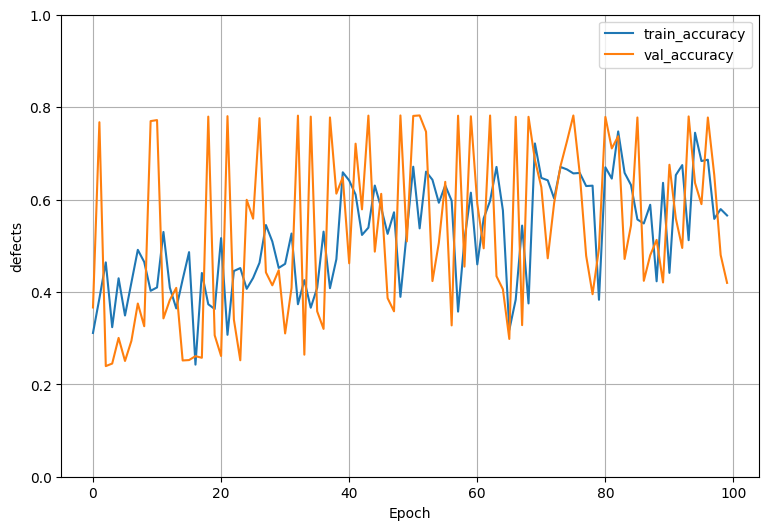

In [38]:
plot_accuracy(history)

In [39]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='train_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('defects')
  plt.legend()
  plt.grid(True)

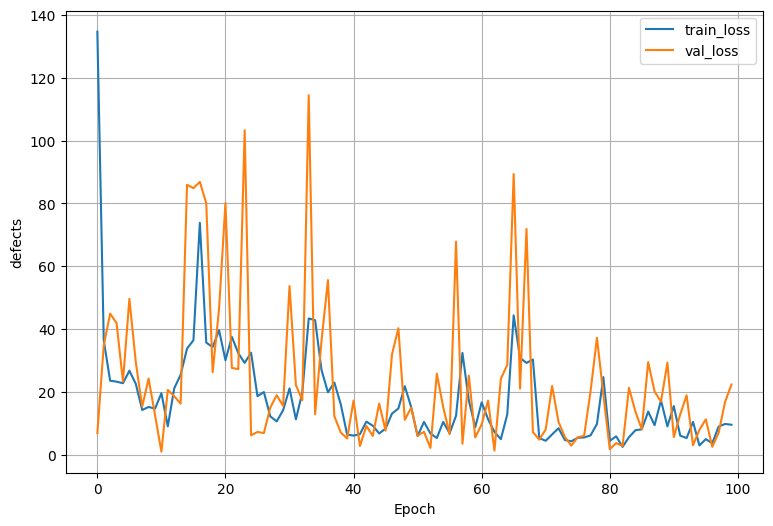

In [40]:
plot_loss(history)

In [41]:
pred0 = model.predict(train_tf)
pred0 = tf.convert_to_tensor(pred0)

3181/3181 [==============================] - 4s 1ms/step


In [42]:
cm = tf.math.confusion_matrix(y_tf,
                        pred0)

cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
cm

<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[0.76269076, 0.23730924],
       [0.4530437 , 0.5469563 ]])>

Text(83.22222222222221, 0.5, 'True')

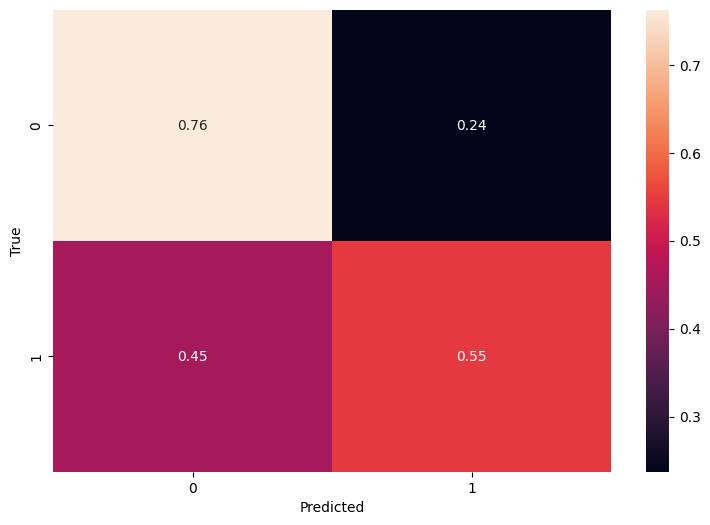

In [43]:
# heat map 
sns.heatmap(
    cm, 
    annot=True
)
plt.xlabel("Predicted")
plt.ylabel("True")

The model did not classify well "1" class 🧐 ? 

we need to solve this !

=== Do not consider anything after this. It is just for next steps === 

In [44]:
# predict 
test_tf = tf.convert_to_tensor(test[train1.columns.to_list()],
                               dtype = tf.float32,)
predictions0 = model.predict(test_tf)
predictions = tf.convert_to_tensor(predictions0)
              
results = pd.DataFrame(predictions)

2121/2121 [==============================] - 3s 1ms/step


In [45]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e23/sample_submission.csv")
sample_submission['defects'] = results
sample_submission.to_csv("submission.csv",index = False) 
!ls

__notebook__.ipynb  submission.csv


In [46]:
pd.read_csv("submission.csv").shape

(67842, 2)

The model needs to be fine tuned!    

let's add a new layer to the model above 😉!

=== to be continued === 